# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
import pylhe, gzip, tempfile
from auxPlots import getInfo
from scipy.interpolate import griddata
import itertools

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disabpd.option_context('display.max_columns', 300)le copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
files = list(glob.glob('../processFolders/*xsecs/Events/*/unweighted_events.lhe.gz'))
# files = [f for f in files[:] if not (('gg2TT_formFactors' in f) and ('run_04' not in f))]
# print(files)

In [3]:
# Get info
fileData = {f : getInfo(f) for f in files}
for fInfo in fileData.values():
    fInfo['mST'] = fInfo['(mST,mChi,mT,yDM)'][0]
    fInfo['mChi'] = fInfo['(mST,mChi,mT,yDM)'][1]
    fInfo['mT'] = fInfo['(mST,mChi,mT,yDM)'][2]
    fInfo['yDM'] = fInfo['(mST,mChi,mT,yDM)'][3]

allModels = sorted(list(set([info['model'] for info in fileData.values()])))
allPars = sorted(list(set([info['(mST,mChi,mT,yDM)'] for info in fileData.values()])))
allProcesses = sorted(list(set([info['process'] for info in fileData.values()])))
# print(allModels)
# print(allPars)
print(allProcesses)

['$g g \\to \\bar{t} t$', '$q q \\to \\bar{t} t$']


In [4]:
# Select files:
models = allModels[:]
pars = allPars[:]
procs = allProcesses[:]

selectedFiles = []
for f,fInfo in fileData.items():
    if fInfo['model'] not in models:
        continue
    if fInfo['process'] not in procs:
        continue
        
    if fInfo['(mST,mChi,mT,yDM)'] not in pars:
        continue
    selectedFiles.append(f)
    
filesDict = [fInfo for f,fInfo in fileData.items() if f in selectedFiles]
    

### Create data frame with cross-sections

In [5]:
allData = pd.DataFrame.from_dict(filesDict)
allData.drop(columns='(mST,mChi,mT,yDM)',inplace=True)
allData.replace(to_replace='$g g \\to \\bar{t} t$', value='gg2tt',inplace=True)
allData.replace(to_replace='$q q \\to \\bar{t} t$', value='qq2tt',inplace=True)

In [6]:
allDataEFT = allData[allData['model'] == 'EFT']
allDataLoop = allData[allData['model'] == '1-loop']
allDataEFT.sort_values(by=['process','mST','mChi'],inplace=True,ignore_index=True)
allDataLoop.sort_values(by=['process','mST','mChi'],inplace=True,ignore_index=True)

In [7]:
len(allDataEFT),len(allDataLoop)

(320, 320)

In [8]:
allDataLoop['xsecEFT (pb)'] = allDataEFT['xsec (pb)']
allDataLoop['ratio'] = allDataLoop['xsec (pb)']/allDataLoop['xsecEFT (pb)']

### gg -> tt

In [9]:
dataGG = allDataLoop[allDataLoop['process']=='gg2tt']

In [10]:
# plt.figure(figsize=(8,5))
# plt.scatter(dataGG['mST'],dataGG['mChi'],c=dataGG['ratio'],s=50,cmap=cm)
# plt.colorbar(label=r'$\sigma_{\rm loop}/\sigma_{\rm EFT}$')
# plt.xlabel(r'$m_{T}$ (GeV)')
# plt.ylabel(r'$m_{\chi}$ (GeV)')
# plt.title(r'$ g g \to \bar{t} t$',fontsize=20)
# plt.grid()
# plt.show()

In [11]:
dataGG['ratio'].min(),dataGG['ratio'].max()

(0.8775174831988909, 0.9957120300082781)

In [12]:
# Interpolate to create more points
xnew = np.linspace(dataGG['mST'].min(),dataGG['mST'].max(),200)
ynew = np.linspace(dataGG['mChi'].min(),dataGG['mChi'].max(),200)
xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
znew = griddata(list(zip(dataGG['mST'],dataGG['mChi'])),dataGG['ratio'],xi=xi,
                method='linear')
znew = np.reshape(znew,(len(xnew),len(ynew)))
x,y  = np.meshgrid(xnew,ynew,indexing='ij')

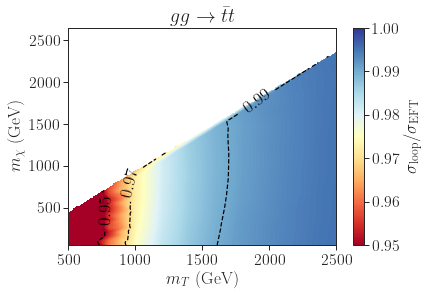

In [13]:
plt.figure(figsize=(6,4))
plt.imshow(znew.T, extent=[x.min(),x.max(), y.min(), y.max()], origin='lower',
                  cmap=cm,aspect='auto',vmin=0.95,vmax=1.0)
plt.colorbar(label=r'$\sigma_{\rm loop}/\sigma_{\rm EFT}$')
plt.xlabel(r'$m_{T}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.title(r'$ g g \to \bar{t} t$',fontsize=20)

contours = plt.contour(x, y, znew, [0.95,0.97, 0.99], colors='black',linestyles='dashed')
plt.clabel(contours, inline=True, fontsize=18)
plt.xlim(500,2500)
plt.show()

### qq -> tt

In [14]:
dataQQ = allDataLoop[allDataLoop['process']=='qq2tt']

In [15]:
# plt.figure(figsize=(8,5))
# plt.scatter(dataQQ['mST'],dataQQ['mChi'],c=dataQQ['ratio'],s=50,cmap=cm,vmin=1.0,vmax=1.05)
# plt.colorbar(label=r'$\sigma_{\rm loop}/\sigma_{\rm EFT}$')
# plt.xlabel(r'$m_{T}$ (GeV)')
# plt.ylabel(r'$m_{\chi}$ (GeV)')
# plt.title(r'$ q q \to \bar{t} t$',fontsize=20)
# plt.grid()
# plt.show()

In [16]:
dataQQ['ratio'].min(),dataQQ['ratio'].max()

(1.014284693950432, 1.537046391500595)

In [17]:
# Interpolate to create more points
xnew = np.linspace(dataQQ['mST'].min(),dataQQ['mST'].max(),200)
ynew = np.linspace(dataQQ['mChi'].min(),dataQQ['mChi'].max(),200)
xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
znew = griddata(list(zip(dataQQ['mST'],dataQQ['mChi'])),dataQQ['ratio'],xi=xi,
                method='linear')
znew = np.reshape(znew,(len(xnew),len(ynew)))
x,y  = np.meshgrid(xnew,ynew,indexing='ij')

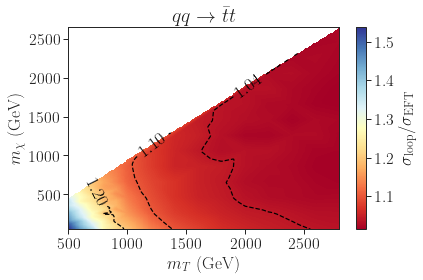

In [18]:
plt.figure(figsize=(6,4))
plt.imshow(znew.T, extent=[x.min(),x.max(), y.min(), y.max()], origin='lower',
                  cmap=cm,aspect='auto')
plt.colorbar(label=r'$\sigma_{\rm loop}/\sigma_{\rm EFT}$')
plt.xlabel(r'$m_{T}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.title(r'$ q q \to \bar{t} t$',fontsize=20)

contours = plt.contour(x, y, znew, [1.04,1.1,1.2], colors='black',linestyles='dashed')
plt.clabel(contours, inline=True, fontsize=18)
plt.tight_layout()
plt.show()